### Importing libraries

In [ ]:
import kagglehub
import os
import zipfile
import shutil
os.getcwd()

'/content'

In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sagarkumaragrawal","key":"f4de2476d3740ff99155271c064d1c52"}'}

In [ ]:
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paramaggarwal/ -product-images-small



Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT


In [ ]:
with zipfile.ZipFile("fashion-product-images-small.zip", 'r') as zip_ref:
  zip_ref.extractall("fashion_data")

print(os.listdir("fashion_data"))


In [ ]:
len(os.listdir('/content/fashion_data/images'))

In [ ]:
print(f"There are {len(os.listdir('/content/fashion_data/myntradataset/images'))} images in the dataset")



In [ ]:
print(f"The size of the dataset is:\n")
!du -sh fashion_data/myntradataset/

### Saving the dataset in my google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
shutil.copytree("fashion_data/myntradataset", "/content/drive/MyDrive/MLBD/Project/data/", dirs_exist_ok=True)


### Model building

In [ ]:
pip install torch torchvision faiss-cpu pillow tqdm matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# pip install faiss-gpu

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import random
import networkx as nx
import torch
from torchvision import models, transforms
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity



In [ ]:
import os
import torch
import numpy as np
import faiss
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from torchvision import models, transforms

class VisualProductRecommender:
    def __init__(self, img_dir, embedding_dim=512):
        self.img_dir = img_dir
        self.embedding_dim = embedding_dim
        self.product_embeddings = {}
        self.product_metadata = defaultdict(dict)
        self.product_ids = []

        # ResNet model initialization
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.feature_extractor.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor.to(self.device)

        # Image transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # FAISS HNSW index
        self.index = None
        self.id_to_index = {}
        self.index_to_id = {}

    def load_and_process_images(self):
        print("Processing images and extracting features...")

        image_files = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        embeddings_list = []

        for idx, filename in enumerate(tqdm(image_files, desc="Extracting features")):
            product_id = os.path.splitext(filename)[0]
            self.product_ids.append(product_id)
            img_path = os.path.join(self.img_dir, filename)

            # Load image and preprocess
            try :
              img = Image.open(img_path).convert("RGB")
              img_tensor = self.transform(img).unsqueeze(0).to(self.device)

            except :
              print(f"Error loading image: {img_path}")
              continue

            with torch.no_grad():
                features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

            self.product_embeddings[product_id] = features
            embeddings_list.append(features)

            # Map product_id to index and vice versa
            self.id_to_index[product_id] = idx
            self.index_to_id[idx] = product_id

            self.product_metadata[product_id] = {
                'filename': filename,
                'path': img_path
            }

        print(f"Processed {len(self.product_ids)} images total.")

        # Convert embeddings to numpy array and build FAISS HNSW index
        embeddings_array = np.array(embeddings_list).astype('float32')
        self._build_faiss_index(embeddings_array)


    def _build_faiss_index(self, embeddings_array):
        print("Building FAISS HNSW index...")

        # Create FAISS HNSW index
        self.index = faiss.IndexHNSWFlat(self.embedding_dim, 16)  # M=16 (connections per layer)
        self.index.hnsw.efConstruction = 100  # Higher values = more accurate but slower construction
        self.index.hnsw.efSearch = 50  # Higher values = more accurate but slower search

        # Add vectors to the index
        self.index.add(embeddings_array)

        print(f"FAISS HNSW index built with {len(embeddings_array)} vectors.")

    def find_similar_products(self, query_pid, k=5):
        """Find similar products using FAISS HNSW index"""
        if query_pid not in self.product_embeddings:
            return []

        # Get query embedding
        query_emb = self.product_embeddings[query_pid].reshape(1, -1).astype('float32')

        # Search for nearest neighbors
        distances, indices = self.index.search(query_emb, k + 1)  # +1 to include self

        # Process results (skip first result if it's the query itself)
        start_idx = 1 if indices[0][0] == self.id_to_index[query_pid] else 0
        results = []

        for i in range(start_idx, min(k + start_idx, len(indices[0]))):
            idx = indices[0][i]
            pid = self.index_to_id[idx]
            distance = distances[0][i]

            results.append({
                'product_id': pid,
                'distance': distance,
                'metadata': self.product_metadata[pid]
            })

        return results

    def find_similar_by_image(self, image_path, k=5):
        """Find similar products using an image that's not in the index"""
        # Load and preprocess image
        img = Image.open(image_path).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

        # Convert to correct format for FAISS
        query_emb = features.reshape(1, -1).astype('float32')

        # Search for nearest neighbors
        distances, indices = self.index.search(query_emb, k)

        # Process results
        results = []
        for i in range(len(indices[0])):
            idx = indices[0][i]
            pid = self.index_to_id[idx]
            distance = distances[0][i]

            results.append({
                'product_id': pid,
                'distance': distance,
                'metadata': self.product_metadata[pid]
            })

        return results

    def visualize_results(self, query_path, results):
        """Visualize query image and similar products"""
        import matplotlib.pyplot as plt

        n = len(results) + 1
        fig, axes = plt.subplots(1, n, figsize=(n * 4, 5))

        # Display query image
        query_img = Image.open(query_path)
        axes[0].imshow(query_img)
        axes[0].set_title("Query Image")
        axes[0].axis('off')

        # Display similar images
        for i, rec in enumerate(results):
            img = Image.open(rec['metadata']['path'])
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Match {i+1}\nDistance: {rec['distance']:.4f}")
            axes[i+1].axis('off')

        plt.tight_layout()
        plt.show()

    def batch_index_images(self, img_dir, batch_size=100):
        """Process and index images in batches for large datasets"""
        image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i+batch_size]
            embeddings_list = []

            for idx, filename in enumerate(tqdm(batch_files, desc=f"Processing batch {i//batch_size + 1}")):
                product_id = os.path.splitext(filename)[0]
                global_idx = i + idx

                self.product_ids.append(product_id)
                img_path = os.path.join(img_dir, filename)

                # Process image
                img = Image.open(img_path).convert("RGB")
                img_tensor = self.transform(img).unsqueeze(0).to(self.device)

                with torch.no_grad():
                    features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

                self.product_embeddings[product_id] = features
                embeddings_list.append(features)

                # Update mappings
                self.id_to_index[product_id] = global_idx
                self.index_to_id[global_idx] = product_id

                self.product_metadata[product_id] = {
                    'filename': filename,
                    'path': img_path
                }

            # Add batch to index
            embeddings_array = np.array(embeddings_list).astype('float32')

            # For first batch, create the index
            if i == 0:
                self.index = faiss.IndexHNSWFlat(self.embedding_dim, 16)
                self.index.hnsw.efConstruction = 100
                self.index.hnsw.efSearch = 50

            # Add vectors to index
            self.index.add(embeddings_array)
            print(f"Added batch {i//batch_size + 1} to index, total vectors: {self.index.ntotal}")

    def save_index(self, filepath):
        """Save the FAISS index and metadata to disk"""
        # Save the FAISS index
        faiss.write_index(self.index, filepath)
        print(f"FAISS index saved to {filepath}")

        # Save metadata (mappings and product information)
        import pickle
        metadata_path = f"{filepath}_metadata.pkl"
        with open(metadata_path, 'wb') as f:
            metadata = {
                'id_to_index': self.id_to_index,
                'index_to_id': self.index_to_id,
                'product_metadata': self.product_metadata,
                'product_ids': self.product_ids,
                'product_embeddings': self.product_embeddings
            }
            pickle.dump(metadata, f)
        print(f"Metadata saved to {metadata_path}")

    def load_index(self, filepath):
        """Load the FAISS index and metadata from disk"""
        # Load the FAISS index
        self.index = faiss.read_index(filepath)
        print(f"Loaded FAISS index with {self.index.ntotal} vectors")

        # Load metadata
        import pickle
        metadata_path = f"{filepath}_metadata.pkl"
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
            self.id_to_index = metadata['id_to_index']
            self.index_to_id = metadata['index_to_id']
            self.product_metadata = metadata['product_metadata']
            self.product_ids = metadata['product_ids']
            self.product_embeddings = metadata['product_embeddings']
        print(f"Metadata loaded: {len(self.product_ids)} products")

In [ ]:
# Path to your image directory
img_dir = '/content/drive/MyDrive/MLBD/Project/data/images/'

# Initialize the recommender
recommender = VisualProductRecommender(img_dir=img_dir)

# Process images and build the FAISS index
recommender.load_and_process_images()

recommender.save_index('/content/drive/MyDrive/MLBD/Project/product_index.faiss')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing images and extracting features...


Extracting features:  27%|██▋       | 11103/40563 [07:05<03:55, 124.92it/s]

Error loading image: /content/drive/MyDrive/MLBD/Project/data/images/47463.jpg


Extracting features: 100%|██████████| 40563/40563 [11:31<00:00, 58.63it/s] 


Processed 40563 images total.
Building FAISS HNSW index...
FAISS HNSW index built with 40562 vectors.
FAISS index saved to /content/drive/MyDrive/MLBD/Project/product_index.faiss
Metadata saved to /content/drive/MyDrive/MLBD/Project/product_index.faiss_metadata.pkl


In [ ]:
# Load index in a new session
recommender2 = VisualProductRecommender(img_dir='')
recommender2.load_index('/content/drive/MyDrive/MLBD/Project/product_index.faiss')

Loaded FAISS index with 40562 vectors
Metadata loaded: 40563 products


In [ ]:
similar_products = recommender2.find_similar_products('33914', k=5)

In [ ]:
similar_products

[{'product_id': '3255',
  'distance': np.float32(0.0),
  'metadata': {'filename': '3255.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/3255.jpg'}},
 {'product_id': '31446',
  'distance': np.float32(96.33105),
  'metadata': {'filename': '31446.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/31446.jpg'}},
 {'product_id': '3860',
  'distance': np.float32(106.72705),
  'metadata': {'filename': '3860.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/3860.jpg'}},
 {'product_id': '33190',
  'distance': np.float32(107.428215),
  'metadata': {'filename': '33190.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/33190.jpg'}},
 {'product_id': '27029',
  'distance': np.float32(109.76756),
  'metadata': {'filename': '27029.jpg',
   'path': '/content/drive/MyDrive/MLBD/Project/data/images/27029.jpg'}}]

In [ ]:
print("\nSimilar products:")
for i, product in enumerate(similar_products):
    print(f"{i+1}. {product['product_id']} (Distance: {product['distance']:.4f})")



Similar products:
1. 3255 (Distance: 0.0000)
2. 31446 (Distance: 96.3310)
3. 3860 (Distance: 106.7271)
4. 33190 (Distance: 107.4282)
5. 27029 (Distance: 109.7676)


In [ ]:
query_path = recommender2.product_metadata['33914']['path']
query_path

'/content/drive/MyDrive/MLBD/Project/data/images/33914.jpg'

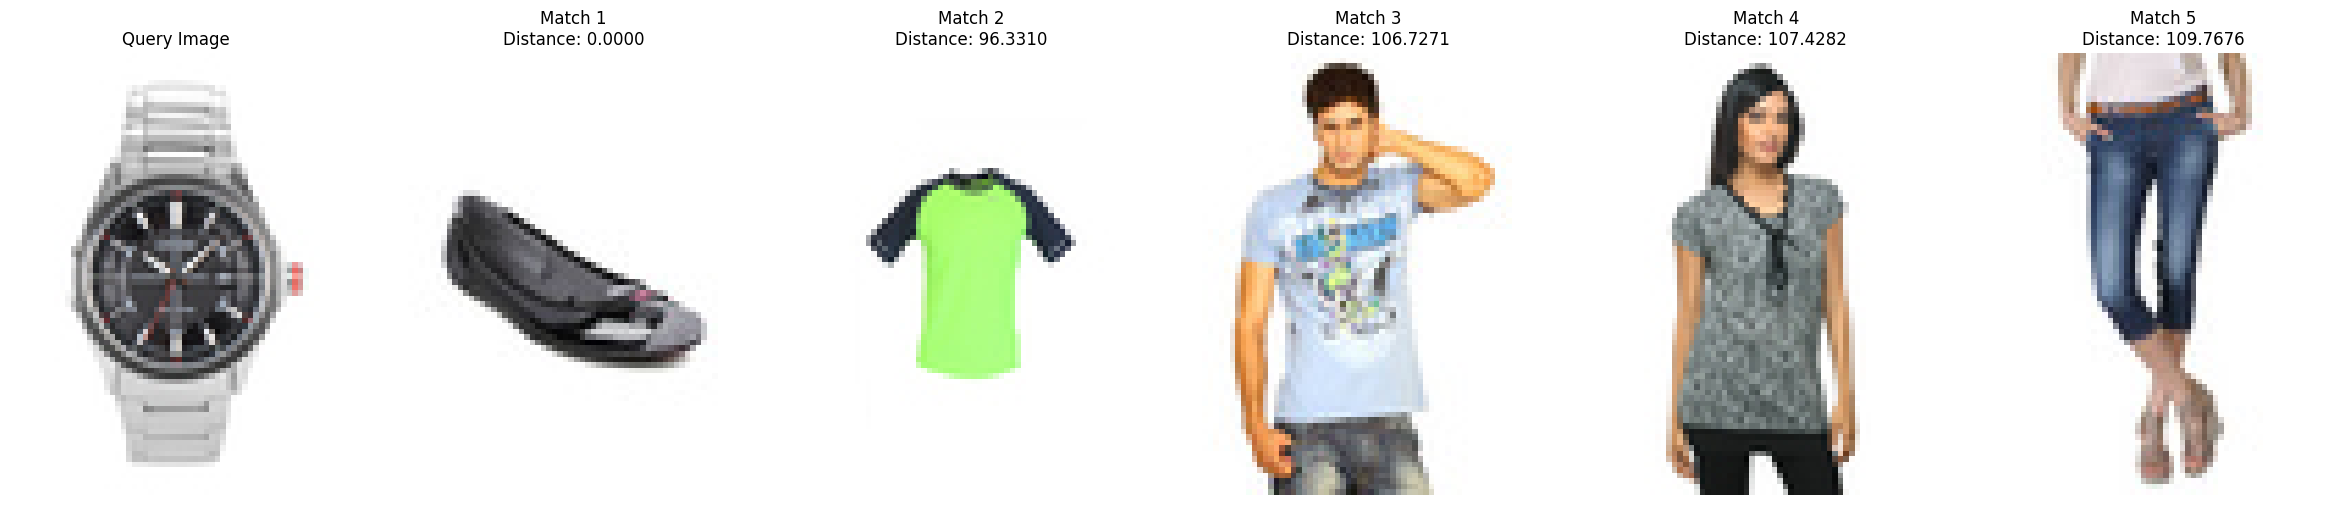

In [ ]:
recommender2.visualize_results(query_path, similar_products)

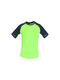

In [ ]:
query_img = Image.open('/content/drive/MyDrive/MLBD/Project/data/images/31446.jpg')
query_img

Finding similar products for: 51624

Similar products:
1. 51623 (Distance: 44.0482)
2. 51622 (Distance: 114.4177)
3. 51630 (Distance: 115.7948)


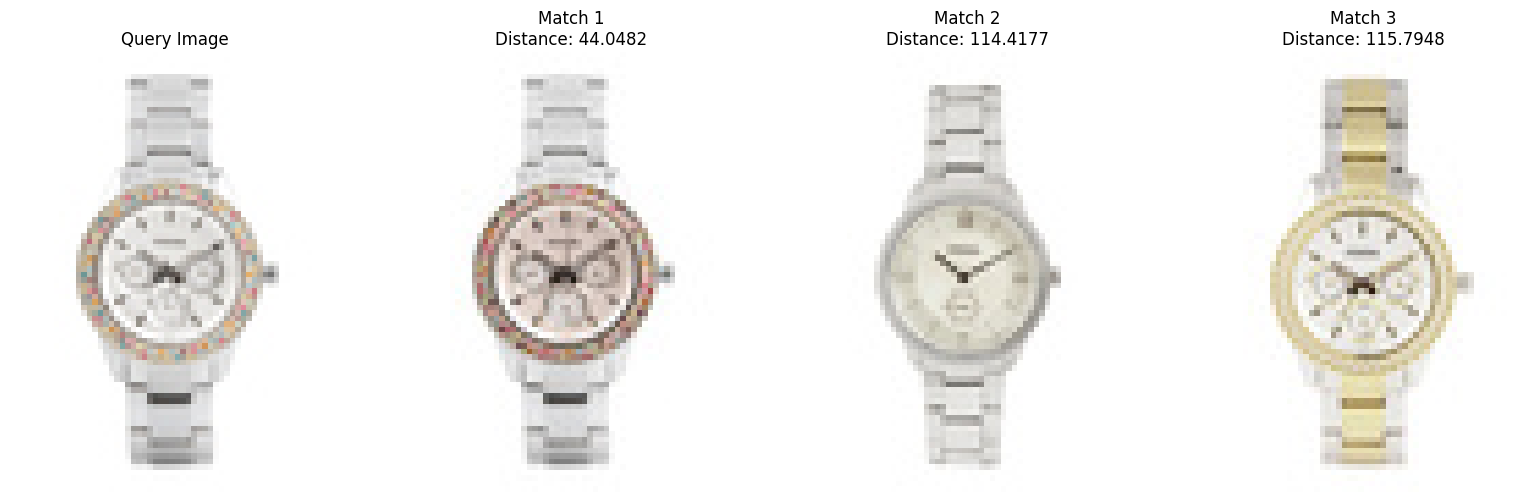

In [ ]:
# Example: Find similar products for the first image
if recommender2.product_ids:
    query_pid = recommender2.product_ids[8000]
    print(f"Finding similar products for: {query_pid}")

    # Get similar products
    similar_products = recommender2.find_similar_products(query_pid, k=3)

    # Display results
    print("\nSimilar products:")
    for i, product in enumerate(similar_products):
        print(f"{i+1}. {product['product_id']} (Distance: {product['distance']:.4f})")

    # Visualize results
    query_path = recommender2.product_metadata[query_pid]['path']
    recommender2.visualize_results(query_path, similar_products)
else:
    print("No products indexed. Check your image directory.")

Finding similar products for: 8729

Similar products:
1. 9621 (Distance: 0.0000)
2. 9644 (Distance: 34.8079)
3. 8739 (Distance: 34.8079)


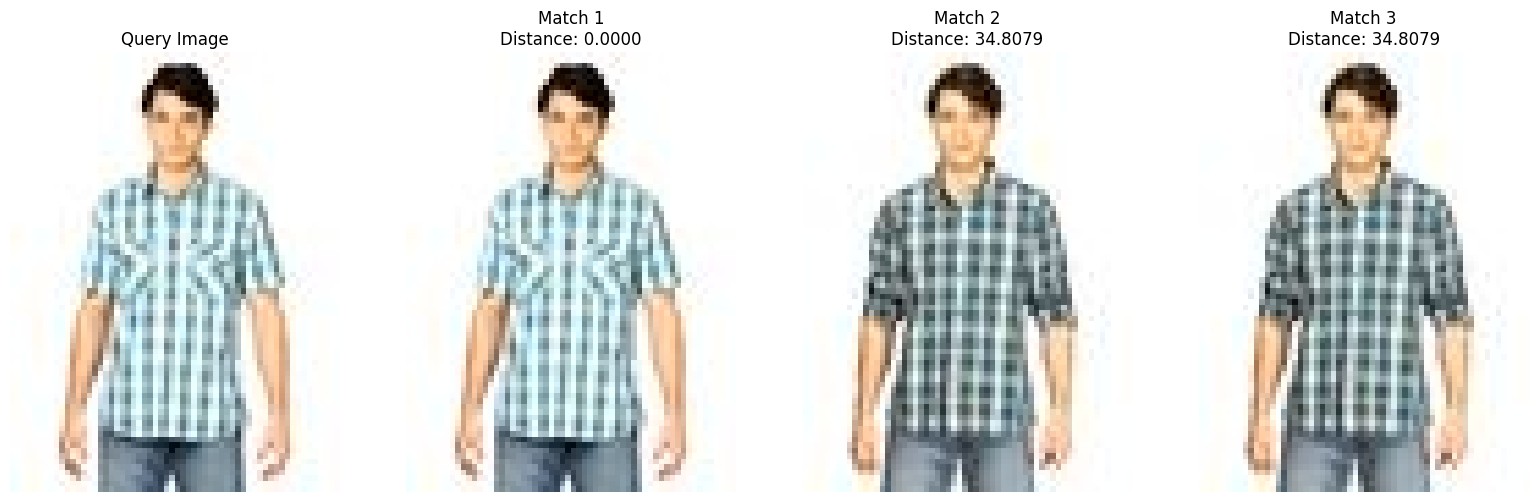

In [ ]:
# Example: Find similar products for the first image
if recommender2.product_ids:
    query_pid = recommender2.product_ids[800]
    print(f"Finding similar products for: {query_pid}")

    # Get similar products
    similar_products = recommender2.find_similar_products(query_pid, k=3)

    # Display results
    print("\nSimilar products:")
    for i, product in enumerate(similar_products):
        print(f"{i+1}. {product['product_id']} (Distance: {product['distance']:.4f})")

    # Visualize results
    query_path = recommender2.product_metadata[query_pid]['path']
    recommender2.visualize_results(query_path, similar_products)
else:
    print("No products indexed. Check your image directory.")

Finding similar products for: 49019

Similar products:
1. 49025 (Distance: 37.9002)
2. 48925 (Distance: 49.5687)
3. 49012 (Distance: 53.2833)


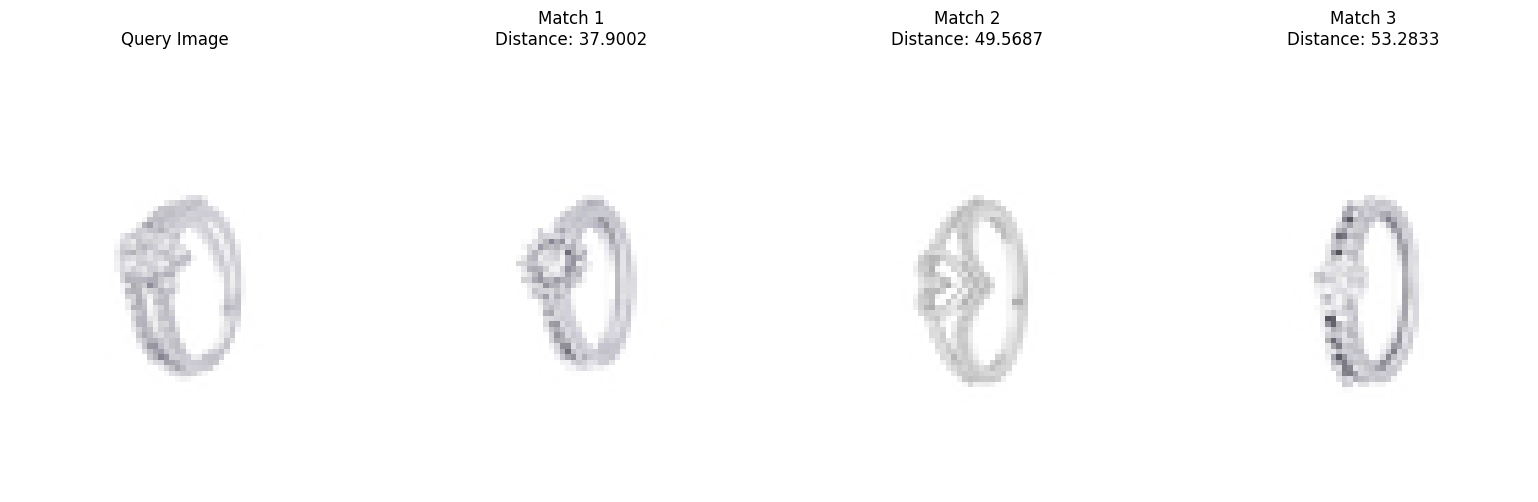

In [ ]:
# Example: Find similar products for the first image
if recommender2.product_ids:
    query_pid = recommender2.product_ids[9800]
    print(f"Finding similar products for: {query_pid}")

    # Get similar products
    similar_products = recommender2.find_similar_products(query_pid, k=3)

    # Display results
    print("\nSimilar products:")
    for i, product in enumerate(similar_products):
        print(f"{i+1}. {product['product_id']} (Distance: {product['distance']:.4f})")

    # Visualize results
    query_path = recommender2.product_metadata[query_pid]['path']
    recommender2.visualize_results(query_path, similar_products)
else:
    print("No products indexed. Check your image directory.")

In [ ]:
!wget https://www.mystore.in/s/62ea2c599d1398fa16dbae0a/6585c4dbda7f92c63e73ff69/t-shirts-for-men-stylish.jpg

--2025-04-19 14:50:21--  https://www.mystore.in/s/62ea2c599d1398fa16dbae0a/6585c4dbda7f92c63e73ff69/t-shirts-for-men-stylish.jpg
Resolving www.mystore.in (www.mystore.in)... 104.18.30.208, 104.18.31.208, 2606:4700::6812:1ed0, ...
Connecting to www.mystore.in (www.mystore.in)|104.18.30.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122040 (119K) [image/jpeg]
Saving to: ‘t-shirts-for-men-stylish.jpg’

t-shirts-for-men-st 100%[===================>] 119.18K  --.-KB/s    in 0.002s  

2025-04-19 14:50:22 (55.2 MB/s) - ‘t-shirts-for-men-stylish.jpg’ saved [122040/122040]



In [ ]:
image_path = '/content/t-shirts-for-men-stylish.jpg'
similar_products = recommender2.find_similar_by_image(image_path, k=3)

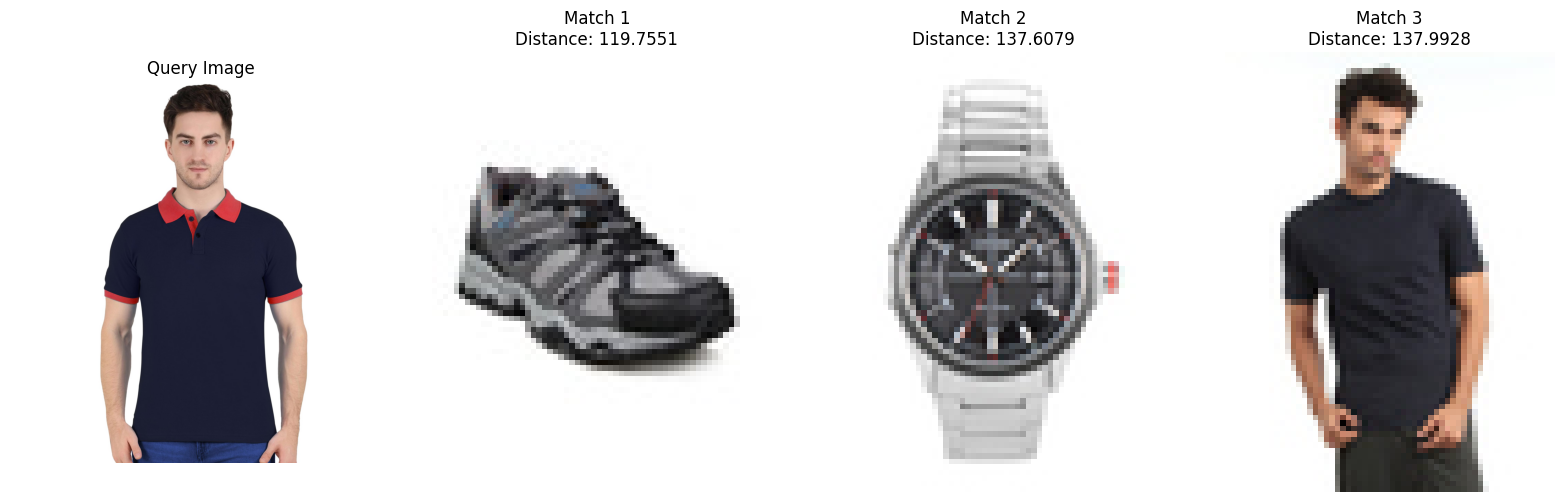

In [ ]:
recommender2.visualize_results(image_path, similar_products)

## PR

In [ ]:
import os
import torch
import numpy as np
import faiss
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

class VisualProductRecommender:
    def __init__(self, img_dir, metadata_path, embedding_dim=512, test_size=0.2, random_state=42):
        self.img_dir = img_dir
        self.embedding_dim = embedding_dim
        self.product_embeddings = {}
        self.product_metadata = defaultdict(dict)
        self.product_ids = []

        # Load metadata
        self.df = pd.read_csv(metadata_path, on_bad_lines='skip')
        self.df = self.df[~self.df.subCategory.isin(['Home Furnishing','Vouchers'])]

        # Perform train-test split
        self.train_df, self.test_df = train_test_split(
            self.df, test_size=test_size, random_state=random_state, stratify=self.df['subCategory']
        )

        print(f"Training set: {len(self.train_df)} products")
        print(f"Test set: {len(self.test_df)} products")

        # Store the product IDs for training and testing
        self.train_ids = self.train_df['id'].astype(str).tolist()
        self.test_ids = self.test_df['id'].astype(str).tolist()

        # ResNet model initialization
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.feature_extractor.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor.to(self.device)

        # Image transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # FAISS HNSW index
        self.index = None
        self.id_to_index = {}
        self.index_to_id = {}

    def load_and_process_images(self):
        """Process and index only training images"""
        print("Processing training images and extracting features...")

        embeddings_list = []

        for idx, product_id in enumerate(tqdm(self.train_ids, desc="Extracting features")):
            # Convert product_id to string if it's not already
            product_id = str(product_id)

            filename = f"{product_id}.jpg"  # Assuming images are named with product ID
            img_path = os.path.join(self.img_dir, filename)

            # Skip if image doesn't exist
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}")
                continue

            self.product_ids.append(product_id)

            # Load image and preprocess
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = self.transform(img).unsqueeze(0).to(self.device)
            except:
                print(f"Error loading image: {img_path}")
                continue

            # Extract features
            with torch.no_grad():
                features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

            self.product_embeddings[product_id] = features
            embeddings_list.append(features)

            # Map product_id to index and vice versa
            self.id_to_index[product_id] = idx
            self.index_to_id[idx] = product_id

            # Store metadata
            product_row = self.train_df[self.train_df['id'].astype(str) == product_id].iloc[0]
            self.product_metadata[product_id] = {
                'filename': filename,
                'path': img_path,
                'subCategory': product_row['subCategory'],
                'articleType': product_row['articleType'],
                'baseColour': product_row['baseColour']
            }

        print(f"Processed {len(self.product_ids)} training images total.")

        # Convert embeddings to numpy array and build FAISS HNSW index
        if embeddings_list:
            embeddings_array = np.array(embeddings_list).astype('float32')
            self._build_faiss_index(embeddings_array)
        else:
            print("No valid embeddings extracted. Check your image paths.")

    def _build_faiss_index(self, embeddings_array):
        print("Building FAISS HNSW index...")

        # Create FAISS HNSW index
        self.index = faiss.IndexHNSWFlat(self.embedding_dim, 16)  # M=16 (connections per layer)
        self.index.hnsw.efConstruction = 100  # Higher values = more accurate but slower construction
        self.index.hnsw.efSearch = 50  # Higher values = more accurate but slower search

        # Add vectors to the index
        self.index.add(embeddings_array)

        print(f"FAISS HNSW index built with {len(embeddings_array)} vectors.")

    def find_similar_products(self, query_pid, k=5):
        """Find similar products using FAISS HNSW index"""
        if query_pid not in self.product_embeddings:
            return []

        # Get query embedding
        query_emb = self.product_embeddings[query_pid].reshape(1, -1).astype('float32')

        # Search for nearest neighbors
        distances, indices = self.index.search(query_emb, k + 1)  # +1 to include self

        # Process results (skip first result if it's the query itself)
        start_idx = 1 if indices[0][0] == self.id_to_index[query_pid] else 0
        results = []

        for i in range(start_idx, min(k + start_idx, len(indices[0]))):
            idx = indices[0][i]
            pid = self.index_to_id[idx]
            distance = distances[0][i]

            results.append({
                'product_id': pid,
                'distance': distance,
                'metadata': self.product_metadata[pid]
            })

        return results

    def find_similar_by_image(self, image_path, k=5):
        """Find similar products using an image that's not in the index"""
        # Load and preprocess image
        try:
            img = Image.open(image_path).convert("RGB")
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        except:
            print(f"Error loading image: {image_path}")
            return []

        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

        # Convert to correct format for FAISS
        query_emb = features.reshape(1, -1).astype('float32')

        # Search for nearest neighbors
        distances, indices = self.index.search(query_emb, k)

        # Process results
        results = []
        for i in range(len(indices[0])):
            idx = indices[0][i]
            pid = self.index_to_id[idx]
            distance = distances[0][i]

            results.append({
                'product_id': pid,
                'distance': distance,
                'metadata': self.product_metadata[pid]
            })

        return results

    def extract_features(self, image_path):
        """Extract features from a single image"""
        try:
            img = Image.open(image_path).convert("RGB")
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        except:
            print(f"Error loading image: {image_path}")
            return None

        # Extract features
        with torch.no_grad():
            features = self.feature_extractor(img_tensor).squeeze().cpu().numpy()

        return features

    def evaluate_precision_recall_at_k(self, k_values=[1, 5, 10]):
        """
        Evaluate precision@k and recall@k using test set
        Uses subCategory as the relevant label
        """
        print("Evaluating precision@k and recall@k on test set...")

        # Initialize metrics storage
        metrics = {k: {'precision': [], 'recall': []} for k in k_values}

        # Process each test image
        for idx, product_id in enumerate(tqdm(self.test_ids, desc="Evaluating test images")):
            product_id = str(product_id)
            filename = f"{product_id}.jpg"
            img_path = os.path.join(self.img_dir, filename)

            if not os.path.exists(img_path):
                continue

            # Get ground truth category
            test_row = self.test_df[self.test_df['id'].astype(str) == product_id]
            if test_row.empty:
                continue

            ground_truth_category = test_row.iloc[0]['subCategory']

            # Extract features and find similar products
            features = self.extract_features(img_path)
            if features is None:
                continue

            # Format query for search
            query_emb = features.reshape(1, -1).astype('float32')

            # Get max k value
            max_k = max(k_values)

            # Search for nearest neighbors
            distances, indices = self.index.search(query_emb, max_k)

            # Calculate metrics for each k value
            for k in k_values:
                # Get top k results
                top_k_indices = indices[0][:k]

                # Get product IDs and categories
                top_k_categories = [self.product_metadata[self.index_to_id[idx]]['subCategory']
                                   for idx in top_k_indices]

                # Calculate precision@k - fraction of retrieved items that are relevant
                relevant_count = sum(1 for category in top_k_categories if category == ground_truth_category)
                precision_at_k = relevant_count / k if k > 0 else 0

                # Calculate recall@k - fraction of relevant items that are retrieved
                # For subCategory, there's only one relevant item per query (the query itself)
                # So recall is either 0 or 1/1 (if at least one matching category was found)
                recall_at_k = min(1.0, relevant_count)

                # Store metrics
                metrics[k]['precision'].append(precision_at_k)
                metrics[k]['recall'].append(recall_at_k)

        # Compute average metrics
        results = {}
        for k in k_values:
            avg_precision = np.mean(metrics[k]['precision']) if metrics[k]['precision'] else 0
            avg_recall = np.mean(metrics[k]['recall']) if metrics[k]['recall'] else 0

            results[k] = {
                'precision': avg_precision,
                'recall': avg_recall
            }

            print(f"Precision@{k}: {avg_precision:.4f}, Recall@{k}: {avg_recall:.4f}")

        return results

    def visualize_results(self, query_path, results):
        """Visualize query image and similar products"""
        import matplotlib.pyplot as plt

        n = len(results) + 1
        fig, axes = plt.subplots(1, n, figsize=(n * 4, 5))

        # Display query image
        query_img = Image.open(query_path)
        axes[0].imshow(query_img)
        axes[0].set_title("Query Image")
        axes[0].axis('off')

        # Display similar images
        for i, rec in enumerate(results):
            img = Image.open(rec['metadata']['path'])
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Match {i+1}\nCategory: {rec['metadata']['subCategory']}\nDistance: {rec['distance']:.4f}")
            axes[i+1].axis('off')

        plt.tight_layout()
        plt.show()

    def save_index(self, filepath):
        """Save the FAISS index and metadata to disk"""
        # Save the FAISS index
        faiss.write_index(self.index, filepath)
        print(f"FAISS index saved to {filepath}")

        # Save metadata (mappings and product information)
        import pickle
        metadata_path = f"{filepath}_metadata.pkl"
        with open(metadata_path, 'wb') as f:
            metadata = {
                'id_to_index': self.id_to_index,
                'index_to_id': self.index_to_id,
                'product_metadata': self.product_metadata,
                'product_ids': self.product_ids,
                'product_embeddings': self.product_embeddings,
                'train_ids': self.train_ids,
                'test_ids': self.test_ids
            }
            pickle.dump(metadata, f)
        print(f"Metadata saved to {metadata_path}")

    def load_index(self, filepath):
        """Load the FAISS index and metadata from disk"""
        # Load the FAISS index
        self.index = faiss.read_index(filepath)
        print(f"Loaded FAISS index with {self.index.ntotal} vectors")

        # Load metadata
        import pickle
        metadata_path = f"{filepath}_metadata.pkl"
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
            self.id_to_index = metadata['id_to_index']
            self.index_to_id = metadata['index_to_id']
            self.product_metadata = metadata['product_metadata']
            self.product_ids = metadata['product_ids']
            self.product_embeddings = metadata['product_embeddings']
            self.train_ids = metadata['train_ids']
            self.test_ids = metadata['test_ids']
        print(f"Metadata loaded: {len(self.product_ids)} products")

In [ ]:
import matplotlib.pyplot as plt

# Initialize the recommender with your data
recommender = VisualProductRecommender(
    img_dir='/content/drive/MyDrive/MLBD/Project/data/images/',
    metadata_path='/content/drive/MyDrive/MLBD/Project/data/styles.csv',
    test_size=0.2,  # 20% of data for testing
    random_state=42  # for reproducibility
)

# Process and index training images
recommender.load_and_process_images()

# Save the index for future use
recommender.save_index('/content/drive/MyDrive/MLBD/Project/product_index_train.faiss')


Training set: 35537 products
Test set: 8885 products


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing training images and extracting features...


Extracting features:  25%|██▌       | 8897/35537 [36:53<1:14:46,  5.94it/s]

Image not found: /content/drive/MyDrive/MLBD/Project/data/images/39403.jpg


Extracting features:  42%|████▏     | 14824/35537 [1:01:30<1:31:23,  3.78it/s]

Image not found: /content/drive/MyDrive/MLBD/Project/data/images/39410.jpg


Extracting features:  80%|███████▉  | 28376/35537 [1:57:21<31:40,  3.77it/s]

Image not found: /content/drive/MyDrive/MLBD/Project/data/images/39401.jpg


Extracting features:  94%|█████████▎| 33312/35537 [2:17:49<08:17,  4.47it/s]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [ ]:

# Evaluate precision and recall at different k values
evaluation_results = recommender.evaluate_precision_recall_at_k(k_values=[1, 5, 10, 20])

# Visualize the evaluation results
k_values = list(evaluation_results.keys())
precision_values = [evaluation_results[k]['precision'] for k in k_values]
recall_values = [evaluation_results[k]['recall'] for k in k_values]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, precision_values, 'o-')
plt.title('Precision@k')
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, recall_values, 'o-')
plt.title('Recall@k')
plt.xlabel('k')
plt.ylabel('Recall')
plt.grid(True)

plt.tight_layout()
plt.show()

# Example of finding similar products for a test image
test_image_id = recommender.test_ids[0]
test_image_path = f"path/to/images_directory/{test_image_id}.jpg"
similar_products = recommender.find_similar_by_image(test_image_path, k=5)

# Visualize the results
recommender.visualize_results(test_image_path, similar_products)

In [ ]:
# Path to your image directory
img_dir = '/content/drive/MyDrive/MLBD/Project/data/images/'

# Initialize the recommender
recommender = VisualProductRecommender(img_dir=img_dir)

# Process images and build the FAISS index
recommender.load_and_process_images()

recommender.save_index('/content/drive/MyDrive/MLBD/Project/product_index_timm.faiss')

Processing images and extracting features...


Extracting features:  48%|████▊     | 21431/44441 [1:37:59<1:45:12,  3.65it/s]  


KeyboardInterrupt: 